In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import io
import re
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
from torch.distributions import Categorical

from torchtext.datasets import WikiText2, EnWik9, AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
from torch.hub import load_state_dict_from_url
from torchtext.data.functional import sentencepiece_tokenizer, load_sp_model

c:\Users\ashmi\Documents\Artificial Intelligence\.venv\Lib\site-packages\torchtext\datasets\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\ashmi\Documents\Artificial Intelligence\.venv\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\ashmi\Documents\Artificial Intelligence\.venv\Lib\site-packages\torchte

In [2]:

learning_rate = 1e-4


nepochs = 40


batch_size = 64


max_len = 64


data_set_root = r"C:\Users\ashmi\Downloads\archive_8\datasets"

In [3]:
from torchtext.data.functional import generate_sp_model

with open(os.path.join(data_set_root, r"train.csv")) as f:
    with open(os.path.join(data_set_root, r"data.txt"), "w") as f2:
        for i, line in enumerate(f):
            text_only = "".join(line.split(",")[1:])
            filtered = re.sub(r'\|\n|;', ' ', text_only.replace('"', ' ').replace('\n', ' '))
            f2.write(filtered.lower() + "\n")

generate_sp_model(os.path.join(data_set_root, r"data.txt"), 
                  vocab_size=20000, model_prefix='spm_user_ya')


In [4]:
print(f"data_set_root: {data_set_root}")


data_set_root: C:\Users\ashmi\Downloads\archive_8\datasets


In [5]:
class AGNews(Dataset):
    def __init__(self, num_datapoints, test_train="train"):
       
        file_path = os.path.join(data_set_root, f"{test_train}.csv")
        
       
        self.df = pd.read_csv(file_path, names=["Class", "Title", "Content"])
        
        self.df.fillna('', inplace=True)
        
       
        self.df['Article'] = self.df['Title'] + " : " + self.df['Content']
        
     
        self.df.drop(['Title', 'Content'], axis=1, inplace=True)
        
        
        self.df['Article'] = self.df['Article'].str.replace(r'\\n|\\|\\r|\\r\\n|\n|"', ' ', regex=True)

    
    def __getitem__(self, index):
   
        text = self.df.loc[index]["Article"].lower()

        return text

   
    def __len__(self):
       
        return len(self.df)




In [6]:

dataset_train = AGNews(num_datapoints=data_set_root, test_train="train")
dataset_test = AGNews(num_datapoints=data_set_root, test_train="test")


data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

In [7]:

sp_model = load_sp_model("spm_user_ya.model")

tokenizer = sentencepiece_tokenizer(sp_model)

for token in tokenizer(["i am creating"]):
    print(token)

['▁i', '▁am', '▁creating']


In [8]:

def yield_tokens(file_path):
   
    with io.open(file_path, encoding='utf-8') as f:
  
        for line in f:
            
            yield [line.split("\t")[0]]

vocab = build_vocab_from_iterator(
    yield_tokens("spm_user_ya.vocab"),
   
    specials=['<pad>', '<sos>', '<eos>', '<unk>'],
    special_first=True
)


vocab.set_default_index(vocab['<unk>'])

In [9]:
class TokenDrop(nn.Module):
    """For a batch of tokens indices, randomly replace a non-specical token with <pad>.
    
    Args:
        prob (float): probability of dropping a token
        pad_token (int): index for the <pad> token
        num_special (int): Number of special tokens, assumed to be at the start of the vocab
    """

    def __init__(self, prob=0.1, pad_token=0, num_special=4):
        self.prob = prob
        self.num_special = num_special
        self.pad_token = pad_token

    def __call__(self, sample):
        
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
     
        can_drop = (sample >= self.num_special).long()
        mask = mask * can_drop
        
        replace_with = (self.pad_token * torch.ones_like(sample)).long()
        
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

In [10]:

train_transform = T.Sequential(
    
    T.SentencePieceTokenizer("spm_ag_news.model"),

    T.VocabTransform(vocab=vocab),
    
    T.AddToken(1, begin=True),
    
    T.Truncate(max_seq_len=max_len),
   
    T.AddToken(2, begin=False),
    
    T.ToTensor(padding_value=0)
)


gen_transform = T.Sequential(

    T.SentencePieceTokenizer("spm_ag_news.model"),
  
    T.VocabTransform(vocab=vocab),
   
    T.AddToken(1, begin=True),
   
    T.ToTensor(padding_value=0)
)

In [11]:

batch = next(iter(data_loader_train))


print("BATCH OUTPUT:")
print(batch)


index = 0


input_tokens = train_transform([batch[index]])


print("SENTENCE")
print(batch[index])

print("TOKENS")
print(vocab.lookup_tokens(input_tokens[0].numpy()))


pred_text = "".join(vocab.lookup_tokens(input_tokens[0].numpy())).replace("▁", " ")
print("TOKENS BACK TO SENTENCE")
print(pred_text)


BATCH OUTPUT:
['debian rejects sender id : developers responsible for the debian linux distribution announced on saturday that they will not implement sender id due to microsoft #39;s insistence on licensing the anti-spam standard.', 'report: mladic gets  $520-a-month serb army pension :  belgrade (reuters) - top war crimes suspect ratko mladic is  getting about  $520 a month in pension payments from the serbia  and montenegro military, the belgrade daily blic reported  wednesday.', 'nortel networks to cut 3,500 : toronto -- nortel networks said yesterday it will slash its workforce by 3,500, or 10 percent, as it struggles to recover from an accounting scandal that toppled three top executives and led to a criminal ...', 'airline warns judge that liquidation is ahead without union pay &lt;b&gt;...&lt;/b&gt; : alexandria, va. us airways is warning a bankruptcy judge that it may have to liquidate as soon as february unless the judge imposes temporary pay cuts of 23 percent on the airline

In [12]:
class LSTM(nn.Module):
    def __init__(self, num_emb, num_layers=1, emb_size=128, hidden_size=128):
        super(LSTM, self).__init__()
        
        self.embedding = nn.Embedding(num_emb, emb_size)

        self.mlp_emb = nn.Sequential(nn.Linear(emb_size, emb_size),
                                     nn.LayerNorm(emb_size),
                                     nn.ELU(),
                                     nn.Linear(emb_size, emb_size))
        
        self.lstm = nn.LSTM(input_size=emb_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=0.25)

        self.mlp_out = nn.Sequential(nn.Linear(hidden_size, hidden_size//2),
                                     nn.LayerNorm(hidden_size//2),
                                     nn.ELU(),
                                     nn.Dropout(0.5),
                                     nn.Linear(hidden_size//2, num_emb))
        
    def forward(self, input_seq, hidden_in, mem_in):
        input_embs = self.embedding(input_seq)
        input_embs = self.mlp_emb(input_embs)
                
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in))
                
        return self.mlp_out(output), hidden_out, mem_out

In [13]:
device = torch.device(1 if torch.cuda.is_available() else 'cpu')

In [14]:
device

device(type='cuda', index=1)

In [15]:
import torch
import torch.optim as optim
import torch.nn as nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


emb_size = 256
hidden_size = 1024


num_layers = 4


lstm_generator = LSTM(num_emb=len(vocab), num_layers=num_layers, 
                      emb_size=emb_size, hidden_size=hidden_size).to(device)


optimizer = optim.Adam(lstm_generator.parameters(), lr=learning_rate, weight_decay=1e-4)


loss_fn = nn.CrossEntropyLoss()


td = TokenDrop(prob=0.1)


training_loss_logger = []


entropy_logger = []




In [16]:

num_model_params = 0
for param in lstm_generator.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 46481699 (Approximately 46 Million) Parameters!


In [17]:

for epoch in trange(0, nepochs, leave=False, desc="Epoch"):
  
    lstm_generator.train()
    steps = 0

    for text in tqdm(data_loader_train, desc="Training", leave=False):
     
        text_tokens = train_transform(list(text)).to(device)
        bs = text_tokens.shape[0]
        
       
        input_text = td(text_tokens[:, 0:-1])
        output_text = text_tokens[:, 1:]
        

        hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        memory = torch.zeros(num_layers, bs, hidden_size, device=device)
        
        
        pred, hidden, memory = lstm_generator(input_text, hidden, memory)


        loss = loss_fn(pred.transpose(1, 2), output_text)
        
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
       
        with torch.no_grad():
            dist = Categorical(logits=pred)
            entropy_logger.append(dist.entropy().mean().item())

Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

In [18]:

torch.save(lstm_generator.state_dict(), 'lstm_generator_model.pth')
print("Model saved successfully.")

Model saved successfully.


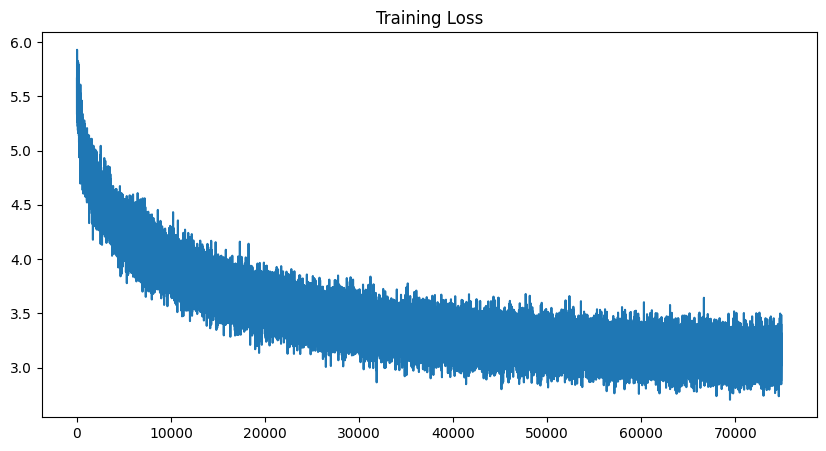

In [19]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(training_loss_logger[100:])
_ = plt.title("Training Loss")

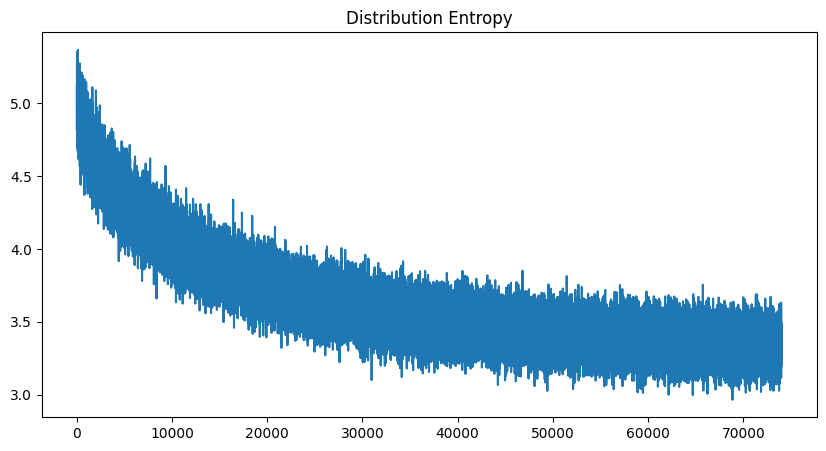

In [20]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(entropy_logger[1000:])
_ = plt.title("Distribution Entropy")

In [27]:

index = 0


temp = 0.9


init_prompt = ["what is google :"]


input_tokens = gen_transform(init_prompt).to(device)

print("INITIAL PROMPT:")
print(init_prompt[0])

print("\nPROMPT TOKENS:")
print(input_tokens)
print(vocab.lookup_tokens(input_tokens[0].cpu().numpy()))

INITIAL PROMPT:
what is google :

PROMPT TOKENS:
tensor([[    1, 19616, 11724, 10475,  4576]], device='cuda:0')
['<sos>', '▁what', '▁is', '▁google', '▁:']


In [28]:
log_tokens = []


lstm_generator.eval()


with torch.no_grad():    

    hidden = torch.zeros(num_layers, 1, hidden_size, device=device)
    memory = torch.zeros(num_layers, 1, hidden_size, device=device)
    

    for i in range(100):

        data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)
        

        dist = Categorical(logits=data_pred[:, -1] / temp)
        input_tokens = dist.sample().reshape(1, 1)

        log_tokens.append(input_tokens.cpu())
        

        if input_tokens.item() == 2:
            break

In [29]:

pred_text = "".join(vocab.lookup_tokens(torch.cat(log_tokens, 1)[0].numpy()))
print(pred_text)

▁a▁10-week▁20-year▁extension▁of▁a▁new▁search▁engine▁icon▁web▁site▁in▁the▁u.s.▁department▁of▁corporate▁information▁has▁introduced▁the▁search▁engine▁to▁the▁search▁engine<unk>▁google▁inc.▁said▁yesterday.▁five▁company▁executives▁behind▁the▁potentially▁all▁of▁the▁all-in-quiet▁equipment▁companies<eos>


In [30]:

init_prompt[0] + pred_text.replace("▁", " ").replace("<unk>", "")

'what is google : a 10-week 20-year extension of a new search engine icon web site in the u.s. department of corporate information has introduced the search engine to the search engine google inc. said yesterday. five company executives behind the potentially all of the all-in-quiet equipment companies<eos>'

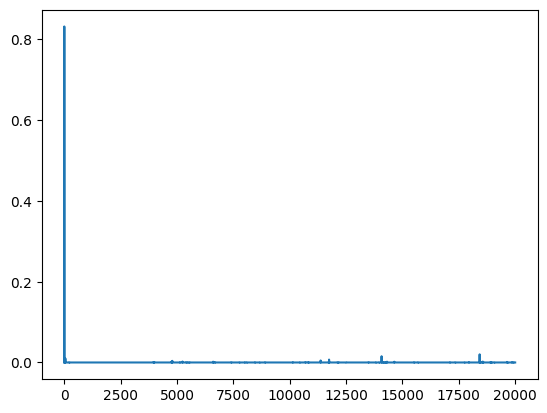

In [26]:
# Lets have a look at the probabilities
_ = plt.plot(F.softmax(data_pred/temp, -1).cpu().numpy().flatten())